![Objective3_CAE_workflows](https://drive.google.com/uc?id=1eD4a_DtxAftzmth3LpkY031oHj_gg0cs)

## Workflow Conclusion

1. This notebook utilizes a Convolutional Autoencoder (CAE) for data compression, followed by data assimilation to optimize the quality of the predicted images. The final optimized Mean Squared Error (MSE) achieved is approximately **0.004**, indicating a good performance.


2. Through a loop-based approach, we determined that the optimal weights for matrix R and matrix B are **10** and **1**, respectively. This combination resulted in the most effective data assimilation.

## Further Considerations and Areas for Improvement

The primary objective of this optimization was to make the predicted and assimilated images as similar to the observation image as possible. However, considering the principles of data assimilation, we reflected on whether the correct optimization goal should be to make the predicted and assimilated images similar to both the observation and background images.

Based on this new optimization goal, we propose an alternative method for selecting the weights for matrices R and B:

- During the weight selection process, calculate the similarity of the assimilated image to both the background image and the observation image, denoted as **ass_background_ssim** and **ass_observation_ssim**, respectively.

- Compute the product of these similarities, **ass_background_ssim * ass_observation_ssim**, and select the weights that maximize this product.

This approach aims to ensure that the final assimilated image closely resembles both the background image and the observation image, potentially leading to a more balanced and accurate optimization.

In [ ]:
import sys
sys.path.append('..')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, TensorDataset
from cae import Autoencoder, load_and_preprocess_data, reshape_and_compute_cov
from cae import compute_covariances, kalman_filter, run_data_assimilation, binarize_image

## Part 1: Data Assimilation with Task 1

### Step 1: load CAE model

In [8]:
model_path = '1616_autoencoder.pth'
map_location = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(map_location)  # Define the device variable
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load(model_path, map_location=device), strict=False)
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='bilinear')
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='bilinear')
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

#### CAE Model Conclusion:

 **A critical design choice in this model is the dimensionality of the latent space representation, particularly the decision to set the final channel dimension to 1.** This decision is motivated by the need to compute a matrix B from the latent space representation. If the channel dimension were larger, say 8, it would result in an excessively large matrix of size 8x64x64, which could hinder the assimilation process due to computational and memory constraints. Therefore, reducing the channel dimension to 1 at the bottleneck layer ensures that the model remains computationally feasible while still capturing the essential features necessary for accurate image reconstruction. This strategic configuration underscores the model's balance between dimensionality reduction and computational efficiency, essential for its intended applications in image processing tasks.

### Step 2: load and preprocess image data

In [9]:
# Paths to data files
background_data_path = 'Ferguson_fire_background.npy'
observation_data_path = 'Ferguson_fire_obs.npy'
predicted_image_path = 'model_preds.npy'

In [10]:
# Load and preprocess original image data
background_data = load_and_preprocess_data(background_data_path)
observation_data = load_and_preprocess_data(observation_data_path)

In [11]:
predicted_images = np.load(predicted_image_path)
predicted_images = torch.tensor(predicted_images).to(device)

In [12]:
# Replace the 3rd, 4th, and last image in background_data with predicted_images
background_data[2:] = predicted_images

#### Preprocessing Image conclusion:

In this data preprocessing stage, we predicted the last three images based on the initial background images. We then replaced the final three images in the background data with these predicted images, resulting in a set of five images for assimilation.

The purpose of this approach is to enable the construction of matrix B, which requires multiple predicted images. With only one predicted image, it would be impossible to construct the necessary matrix for the assimilation process. By using five images, we ensure that we have a sufficient data set to effectively perform data assimilation and improve the accuracy of our results.

### Step 3: compress data into latent space

In [13]:
with torch.no_grad():
    encoded_background_data = autoencoder.encoder(background_data).view(len(background_data), -1).cpu()
    encoded_observation_data = autoencoder.encoder(observation_data).view(len(observation_data), -1).cpu()

### Step 4: calculate matrix B and R in the reduced space

In [14]:
B, R = compute_covariances(encoded_background_data, encoded_observation_data)

### Step 5: Assimilate data

In [15]:
# Run data assimilation
alpha = 1  # Adjust the weight of background data
beta = 10.0  # Adjust the weight of observation data
assimilated_data = run_data_assimilation(encoded_background_data.numpy(), encoded_observation_data.numpy(), B, R, alpha, beta)

#### Assimilation Data Conclusion:

In this step, I experimented with values of alpha and beta from the set {0.1, 1, 5, 10, 20}. By iterating through all possible pairs and calculating the mean squared error (MSE) for each combination, I discovered that the MSE was minimized when **alpha = 1 and beta = 10**, as shown in this notebook.

The primary reason for this result is that when beta, the weight of the matrix R, is larger, the assimilation process relies more heavily on the observation data. Consequently, the calculated MSE with respect to the observation image is smaller. This indicates that the assimilation process benefits from giving more weight to the observation data to achieve a closer match and lower error.

In [307]:
# Decode data
decoded_background_data = autoencoder.decoder(torch.tensor(encoded_background_data.numpy()).view(len(background_data), 1, 64, 64).to(device)).cpu().detach().numpy()
decoded_assimilated_data = autoencoder.decoder(torch.tensor(assimilated_data.astype(np.float32)).view(len(background_data), 1, 64, 64).to(device)).cpu().detach().numpy()
decoded_observation_data = autoencoder.decoder(torch.tensor(encoded_observation_data.numpy()).view(len(observation_data), 1, 64, 64).to(device)).cpu().detach().numpy()

### Step 6: calculate mse before and after data assimilation

In [308]:
# Calculate the MSE of the last image before assimilation (in reduced space)
mse_before_reduced = mean_squared_error(encoded_background_data[-1].numpy(), encoded_observation_data[-1].numpy())
print(f"MSE before assimilation (reduced space, last image): {mse_before_reduced}")

# Calculate the MSE of the last image after assimilation (in reduced space)
mse_after_reduced = mean_squared_error(assimilated_data[-1], encoded_observation_data[-1].numpy())
print(f"MSE after assimilation (reduced space, last image): {mse_after_reduced}")

# Calculate the MSE of the last image before assimilation (in original space)
mse_before_original = mean_squared_error(decoded_background_data[-1].reshape(1, -1), decoded_observation_data[-1].reshape(1, -1))
print(f"MSE before assimilation (original space, last image): {mse_before_original}")

# Calculate the MSE of the last image after assimilation (in original space)
mse_after_original = mean_squared_error(decoded_assimilated_data[-1].reshape(1, -1), decoded_observation_data[-1].reshape(1, -1))
print(f"MSE after assimilation (original space, last image): {mse_after_original}")


MSE before assimilation (reduced space, last image): 1.0070509910583496
MSE after assimilation (reduced space, last image): 0.04691664536589514
MSE before assimilation (original space, last image): 0.10530707985162735
MSE after assimilation (original space, last image): 0.004496689420193434


### Step 7: visualisation

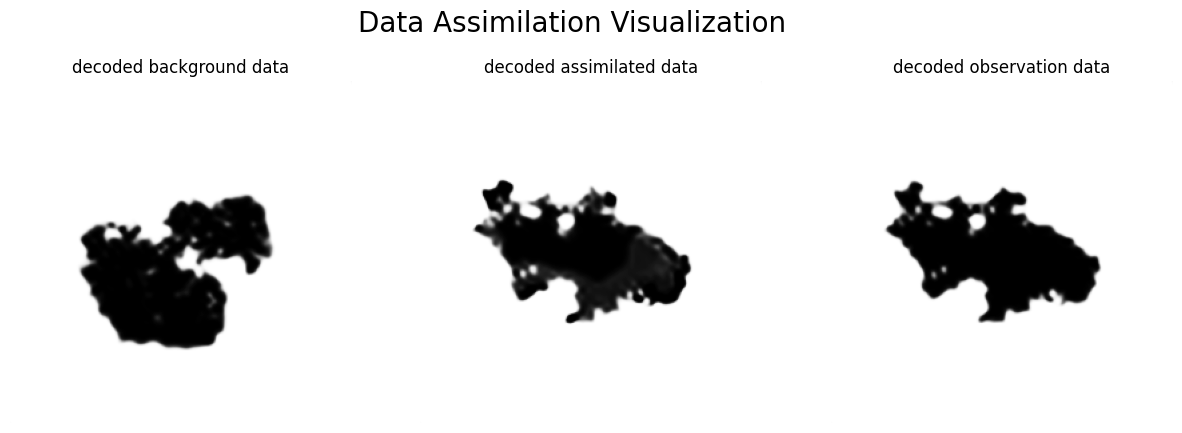

In [309]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles
fig.suptitle("Data Assimilation Visualization", fontsize=20)

axes[0].imshow(decoded_background_data[-1].reshape(256, 256), cmap='gray_r')
axes[0].set_title(f"decoded background data")
axes[0].axis('off')

axes[1].imshow(decoded_assimilated_data[-1].reshape(256, 256), cmap='gray_r')
axes[1].set_title(f"decoded assimilated data")
axes[1].axis('off')

axes[2].imshow(decoded_observation_data[-1].reshape(256, 256), cmap='gray_r')
axes[2].set_title(f"decoded observation data")
axes[2].axis('off')

plt.show()

## Part 2: Data Assimilation with Task 2

### Step 1: load and preprocess image data

In [310]:
# Paths to data files
background_data_path = 'Ferguson_fire_background.npy'
observation_data_path = 'Ferguson_fire_obs.npy'
predicted_image_path = 'objective2_da_images.npy'

In [311]:
# Load and preprocess original image data
background_data = load_and_preprocess_data(background_data_path)
observation_data = load_and_preprocess_data(observation_data_path)

In [312]:
predicted_images = np.load(predicted_image_path)
predicted_images = torch.tensor(predicted_images).to(device)

In [315]:
# Replace the 3rd, 4th, and last image in background_data with predicted_images
background_data[2:] = predicted_images

### Step 3: compress data into latent space

In [316]:
with torch.no_grad():
    encoded_background_data = autoencoder.encoder(background_data).view(len(background_data), -1).cpu()
    encoded_observation_data = autoencoder.encoder(observation_data).view(len(observation_data), -1).cpu()

### Step 4: calculate matrix B and R in the reduced space

In [317]:
B, R = compute_covariances(encoded_background_data, encoded_observation_data)

### Step 5: Assimilate data

In [318]:
# Run data assimilation
alpha = 1  # Adjust the weight of background data
beta = 10.0  # Adjust the weight of observation data
assimilated_data = run_data_assimilation(encoded_background_data.numpy(), encoded_observation_data.numpy(), B, R, alpha, beta)

In [319]:
# Decode data
decoded_background_data = autoencoder.decoder(torch.tensor(encoded_background_data.numpy()).view(len(background_data), 1, 64, 64).to(device)).cpu().detach().numpy()
decoded_assimilated_data = autoencoder.decoder(torch.tensor(assimilated_data.astype(np.float32)).view(len(background_data), 1, 64, 64).to(device)).cpu().detach().numpy()
decoded_observation_data = autoencoder.decoder(torch.tensor(encoded_observation_data.numpy()).view(len(observation_data), 1, 64, 64).to(device)).cpu().detach().numpy()

### Step 6: calculate mse before and after data assimilation

In [320]:
# Calculate the MSE of the last image before assimilation (in reduced space)
mse_before_reduced = mean_squared_error(encoded_background_data[-1].numpy(), encoded_observation_data[-1].numpy())
print(f"MSE before assimilation (reduced space, last image): {mse_before_reduced}")

# Calculate the MSE of the last image after assimilation (in reduced space)
mse_after_reduced = mean_squared_error(assimilated_data[-1], encoded_observation_data[-1].numpy())
print(f"MSE after assimilation (reduced space, last image): {mse_after_reduced}")

# Calculate the MSE of the last image before assimilation (in original space)
mse_before_original = mean_squared_error(decoded_background_data[-1].reshape(1, -1), decoded_observation_data[-1].reshape(1, -1))
print(f"MSE before assimilation (original space, last image): {mse_before_original}")

# Calculate the MSE of the last image after assimilation (in original space)
mse_after_original = mean_squared_error(decoded_assimilated_data[-1].reshape(1, -1), decoded_observation_data[-1].reshape(1, -1))
print(f"MSE after assimilation (original space, last image): {mse_after_original}")


MSE before assimilation (reduced space, last image): 0.9884241223335266
MSE after assimilation (reduced space, last image): 0.04422957088769836
MSE before assimilation (original space, last image): 0.10596024990081787
MSE after assimilation (original space, last image): 0.004637463483959436


### Step 7: visualisation

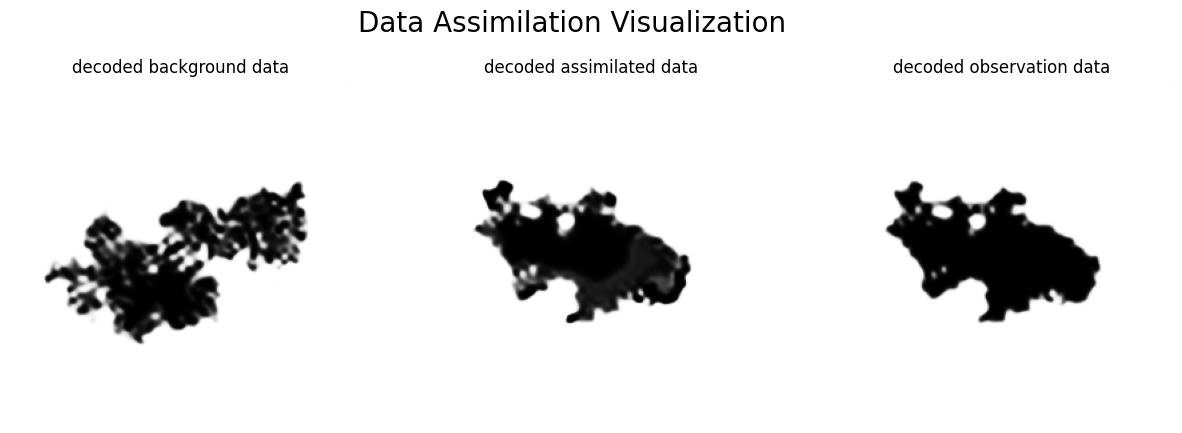

In [321]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set titles
fig.suptitle("Data Assimilation Visualization", fontsize=20)

axes[0].imshow(decoded_background_data[-1].reshape(256, 256), cmap='gray_r')
axes[0].set_title(f"decoded background data")
axes[0].axis('off')

axes[1].imshow(decoded_assimilated_data[-1].reshape(256, 256), cmap='gray_r')
axes[1].set_title(f"decoded assimilated data")
axes[1].axis('off')

axes[2].imshow(decoded_observation_data[-1].reshape(256, 256), cmap='gray_r')
axes[2].set_title(f"decoded observation data")
axes[2].axis('off')

plt.show()